In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow.keras.layers as tfl
import tensorflow.keras.backend as K
from tensorflow.keras.applications import DenseNet169

In [ ]:
print(f'Using Keras version {tf.keras.__version__}')
print(f'Using TensorFlow version {tf.__version__}')

Using Keras version 3.5.0
Using TensorFlow version 2.17.1


In [ ]:
def shuffle_in_place(a, b, c):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    np.random.set_state(rng_state)
    np.random.shuffle(c)

In [ ]:
CLASS_DICT = {
    0: 'car',
    1: 'trash container',
    2: "bicycle"
}

def decode_class(cl_index):
    return CLASS_DICT[cl_index]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load the data and print some important information about it
X_orig = np.load('/content/drive/MyDrive/CS230 /Toy Data/X_NEW.npy')
Y_orig = np.load('/content/drive/MyDrive/CS230 /Toy Data/Y_NEW.npy')
classes = np.load('/content/drive/MyDrive/CS230 /Toy Data/Y_NEW_classes.npy')

# resizing for the gradients loss fn
Y_shape = Y_orig.shape
Y_orig = np.resize(Y_orig, (Y_shape[0], Y_shape[1], Y_shape[2], 1))

# shuffle the toyset
shuffle_in_place(X_orig, Y_orig, classes)

X_train, X_test = X_orig, None
Y_train, Y_test = Y_orig, None
classes_train = classes
# classes_train = tf.reshape(tf.one_hot(classes_train, 3), shape=[600, 3])

# normalize
X_train = tf.convert_to_tensor(X_train/255)
Y_train = tf.convert_to_tensor(Y_train/1000)

print ("number of training examples = " + str(X_train.shape[0]))

print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print("class vector shape: " + str(classes_train.shape))

# set the max depth value for the loss fn
MAX_DEPTH = np.max(Y_train) - np.min(Y_train)
print(f'MAX_DEPTH = {MAX_DEPTH}')

# set the cmap
cmap='plasma_r'

number of training examples = 3513
X_train shape: (3513, 96, 128, 3)
Y_train shape: (3513, 96, 128, 1)
class vector shape: (3513, 1)
MAX_DEPTH = 12.085999999999999


bicycle


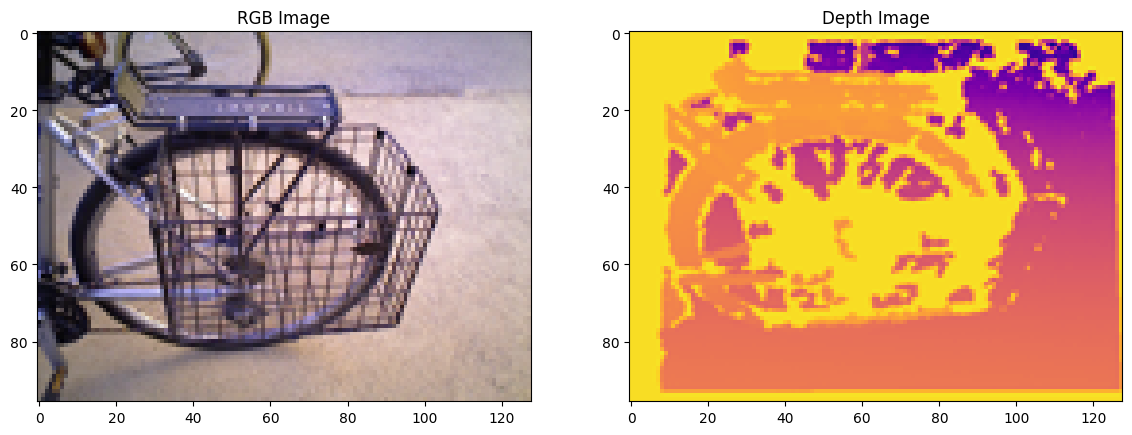

In [ ]:
# look at various images
image_num = 0
fig, arr = plt.subplots(1, 2, figsize=(14, 7))
arr[0].imshow(X_train[image_num])
arr[0].set_title(f'RGB Image')
arr[1].imshow(Y_train[image_num], cmap=cmap)
arr[1].set_title('Depth Image')
print(decode_class(classes_train[image_num][0]))

### U NET ARCHITECHTURE ###

1. Contracting Block (downsample/encode) --> using transfer learning from DenseNet169
2. Skip connection (Concatenation)
3. Expanding Block (upsample/decode)
4. Final Feature Mapping (1x1 conv)

Used the framework from https://arxiv.org/abs/1812.11941

In [ ]:
def UpScaleBlock(expansive_input, concat_layer, concat=True, n_filters=32):
    '''
    Convolutional upsampling block

    Arguments:
        expansive_input -- input to be upsampled
        concat_layer -- skip connection from the previous layer
        concat (bool) -- whether or not to include the skip
        n_filters -- # of filters
    Returns:
        reluB -- upsampled relu output tensor
    '''

    up = tfl.UpSampling2D(size=(2, 2), interpolation='bilinear')(expansive_input)
    if concat:
        concatenated = tfl.concatenate([up, concat_layer], axis=-1)
        convA = tfl.Conv2D(n_filters, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(concatenated)
    else:
        convA = tfl.Conv2D(n_filters, kernel_size=3, strides=1, padding='same')(up)

    bnA = tfl.BatchNormalization()(convA)
    reluA = tfl.LeakyReLU(negative_slope=0.2)(bnA)
    convB = tfl.Conv2D(n_filters, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(reluA)
    bnB = tfl.BatchNormalization()(convB)
    reluB = tfl.LeakyReLU(negative_slope=0.2)(convB)

    return reluB

In [ ]:
def loss_function(y_true, y_pred, lmbda=0.1, max_depth_value=MAX_DEPTH):
    '''
    Custom loss Fn

    Arguments:
        y_true, y_pred -- according to tf, ground truth and model prediction
        lmbda -- MAE loss weight (0.1 default)
        max_depth_value -- max depth occurring anywhere in the image
    Returns
        Weighted sum of the 3 loss terms
    '''

    # point-wise depth loss (MAE term)
    l_MAE = K.mean(K.abs(y_pred - y_true), axis=-1)

    # gradient loss
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

    # l_ssim term
    l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, max_depth_value)) * 0.5, 0, 1)

    return 0.85*l_ssim + 0.9*K.mean(l_edges) + lmbda*K.mean(l_MAE)

In [ ]:
densenet = DenseNet169(include_top=False, input_shape=(96, 128, 3))
densenet.layers[-1].output[0].shape[-1]//2

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


832

In [1]:
def M_Unet(input_size=(96, 128, 3), n_filters=32, fine_tune=False, fine_tune_at=None):
    '''
    Transfer learning model. Call the base model DenseNet169, feed its output to our upsampling layers

    Arguments:
        inputs_size -- size of input
        n_filters -- # of filters
        fine_tune (bool) -- whether to unlock layers of the base for fine tuning
        fine_tune_at (int) -- how many layers to unlock. ignored if fine_tune=False
    Returns:
        tf.keras.Model instance
    '''

    # load the base model and freeze it
    inputs = tfl.Input(input_size)

    base_model = DenseNet169(include_top=False, weights='imagenet', input_shape=input_size, input_tensor=inputs)
    base_model.trainable=False

    # option to fine tune the model
    if fine_tune:
        base_model.trainable=True
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False

    # grab the names of the concat layers
    concat_layers = ['pool1', 'pool2_pool', 'pool3_pool', 'conv1_relu']

    mid = base_model(inputs, training=False)

    # u net for the depth estimation
    bottleneck = tfl.Conv2D(n_filters*16, kernel_size=1, padding="same")(mid)
    ublock1 = UpScaleBlock(bottleneck, base_model.get_layer(concat_layers[2]).output, n_filters=n_filters*8)
    ublock2 = UpScaleBlock(ublock1, base_model.get_layer(concat_layers[1]).output, n_filters=n_filters*4)
    ublock3 = UpScaleBlock(ublock2, base_model.get_layer(concat_layers[0]).output, n_filters=n_filters*2)
    ublock4 = UpScaleBlock(ublock3, base_model.get_layer(concat_layers[3]).output, n_filters=n_filters)
    ublock5 = UpScaleBlock(ublock4, None, concat=False)

    outputs_depth = tfl.Conv2D(filters=1, kernel_size=3, strides=1, padding='same', activation='linear', name='depth')(ublock5)

    # classification layer for common objects
    poolblock = tfl.GlobalAveragePooling2D()(mid)
    dropout = tfl.Dropout(0.2)(poolblock)

    outputs_classifier = tfl.Dense(3, activation='softmax', name='classes')(dropout)

    model = tf.keras.Model(inputs=inputs, outputs={'depth': outputs_depth, 'classes': outputs_classifier})
    print(inputs, '\n', outputs_depth, '\n',  outputs_classifier)
    return model


In [2]:
# grab the model and print its summary
model = M_Unet(n_filters=(832//16))
model.summary(show_trainable=True, line_length=100)

NameError: name 'tfl' is not defined

In [ ]:
# compile the model with a learning rate decay scheduler
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(0.0001, decay_steps=50, decay_rate=0.99, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, amsgrad=True)

model.compile(optimizer=optimizer,
              loss={
                  'depth': loss_function,
                  'classes': 'sparse_categorical_crossentropy'
              },
              metrics={
                  'depth': 'mae',
                  'classes': tf.metrics.SparseCategoricalAccuracy
              })

In [ ]:
EPOCHS = 30
BATCH_SIZE = 16
tf.keras.config.disable_traceback_filtering()


# save the model at the best
checkpoint_path = ".tf_checkpoints/checkpoint-resnet-test-{epoch:04d}.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         verbose=1,
                                                         save_weights_only=True,
                                                         save_best_only=True)


# train the model
history = model.fit(X_train,
                    {
                        'depth': Y_train,
                        'classes': classes_train
                    },
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=[checkpoint_callback],
                    validation_split=0.1)


SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-87-89d0b0239450>, line 24)

In [ ]:
# save the model
model.save_weights('/content/drive/MyDrive/CS230 /model-11-30-2024.weights.h5')

In [ ]:
# load the model and continue to train it
new_model = M_Unet(n_filters=(832//16))
new_model.load_weights('/content/drive/MyDrive/CS230 /model-11-30-2024.weights.h5')

scheduler = tf.keras.optimizers.schedules.ExponentialDecay(0.0001, decay_steps=1000, decay_rate=0.9, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler, amsgrad=True)

new_model.compile(optimizer=optimizer,
              loss={
                  'depth': loss_function,
                  'classes': 'sparse_categorical_crossentropy'
              },
              metrics={
                  'depth': 'mae',
                  'classes': tf.metrics.SparseCategoricalAccuracy
              })

<KerasTensor shape=(None, 96, 128, 3), dtype=float32, sparse=False, name=keras_tensor_5589> 
 <KerasTensor shape=(None, 96, 128, 1), dtype=float32, sparse=False, name=keras_tensor_6225> 
 <KerasTensor shape=(None, 3), dtype=float32, sparse=False, name=keras_tensor_6228>


In [ ]:
EPOCHS = 100
BATCH_SIZE = 16
tf.keras.config.disable_traceback_filtering()


# save the model at the best
checkpoint_path = "/content/drive/MyDrive/CS230 /model-11-30-2024-continuation-00.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         verbose=1,
                                                         save_weights_only=True,
                                                         save_best_only=True)


# train the model
history = new_model.fit(X_train,
                    {
                        'depth': Y_train,
                        'classes': classes_train
                    },
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    initial_epoch=30,
                    callbacks=[checkpoint_callback],
                    validation_split=0.1)

Epoch 31/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - classes_loss: 0.0403 - classes_sparse_categorical_accuracy: 0.9898 - depth_loss: 0.2983 - depth_mae: 0.2920 - loss: 0.3385
Epoch 31: val_loss improved from inf to 0.38713, saving model to /content/drive/MyDrive/CS230 /model-11-30-2024-continuation-00.weights.h5
198/198 ━━━━━━━━━━━━━━━━━━━━ 92s 252ms/step - classes_loss: 0.0402 - classes_sparse_categorical_accuracy: 0.9898 - depth_loss: 0.2982 - depth_mae: 0.2920 - loss: 0.3385 - val_classes_loss: 0.0570 - val_classes_sparse_categorical_accuracy: 0.9858 - val_depth_loss: 0.3301 - val_depth_mae: 0.3803 - val_loss: 0.3871
Epoch 32/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - classes_loss: 0.0381 - classes_sparse_categorical_accuracy: 0.9866 - depth_loss: 0.2955 - depth_mae: 0.2870 - loss: 0.3336
Epoch 32: val_loss improved from 0.38713 to 0.38482, saving model to /content/drive/MyDrive/CS230 /model-11-30-2024-continuation-00.weights.h5
198/198 ━━━━━━━━━━━━━━━━━━━━ 40s 126ms/step

dict_keys(['classes_loss', 'classes_sparse_categorical_accuracy', 'depth_loss', 'depth_mae', 'loss', 'val_classes_loss', 'val_classes_sparse_categorical_accuracy', 'val_depth_loss', 'val_depth_mae', 'val_loss'])


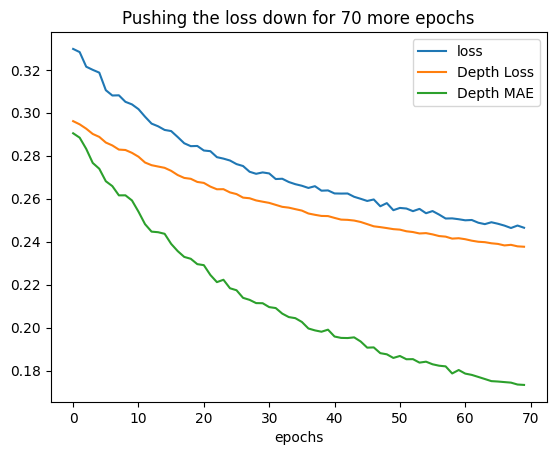

<Figure size 640x480 with 0 Axes>

In [ ]:
print(history.history.keys())
plt.plot(history.history['loss'], label='loss')

#plt.plot(history.history['classes_loss'], label='Classes Loss')
#plt.plot(history.history['classes_sparse_categorical_accuracy'], label='Classes Accuracy')

plt.plot(history.history['depth_loss'], label='Depth Loss')
plt.plot(history.history['depth_mae'], label='Depth MAE')

plt.title('Pushing the loss down for 70 more epochs')
plt.xlabel('epochs')
plt.legend()
plt.show()
plt.savefig('/content/drive/MyDrive/CS230 /Figures/stagnated-learning.jpg')

In [ ]:
def show_predictions(images, ground_truth, nums=[0, 1, 2]):
    '''
    Cute wrapper to pick an image, show its GT and prediction. Use on train or test set

    Arguments:
    images -- RGB image
    ground_truth -- GT depth
    num -- index of the image you want to predict

    TODO: add functionality for showing predictions of images without GT

    Returns:
    Nothing. Shows plt.figure on call
    '''

    fig, arr = plt.subplots(len(nums), 3, figsize=(12, len(nums)*4))

    for i in range(len(nums)):
      test_predict = np.reshape(images[nums[i]], (1, 96, 128, 3))
      test_truth = np.reshape(ground_truth[nums[i]], (1, 96, 128, 1))
      prediction = new_model.predict(test_predict)

      arr[i, 0].imshow(images[nums[i]])
      arr[i, 0].set_title('Original Image')

      vmax, vmin = np.max(ground_truth[nums[i]]), np.min(ground_truth[nums[i]])

      arr[i, 1].imshow(ground_truth[nums[i]], cmap=cmap, vmax=vmax, vmin=vmin)
      arr[i, 1].set_title('Ground Truth Map')

      arr[i, 2].imshow(prediction['depth'][0, :, :, :], cmap=cmap, vmax=vmax, vmin=vmin)
      arr[i, 2].set_title('Predicted Map')
      class_prediction = np.argmax(prediction['classes'][0])

      print(f'the model thinks this image number {nums[i]} is a {decode_class(class_prediction)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
the model thinks this image number 90 is a trash container
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
the model thinks this image number 878 is a car
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
the model thinks this image number 326 is a trash container
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
the model thinks this image number 57 is a car
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
the model thinks this image number 267 is a bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
the model thinks this image number 264 is a bicycle


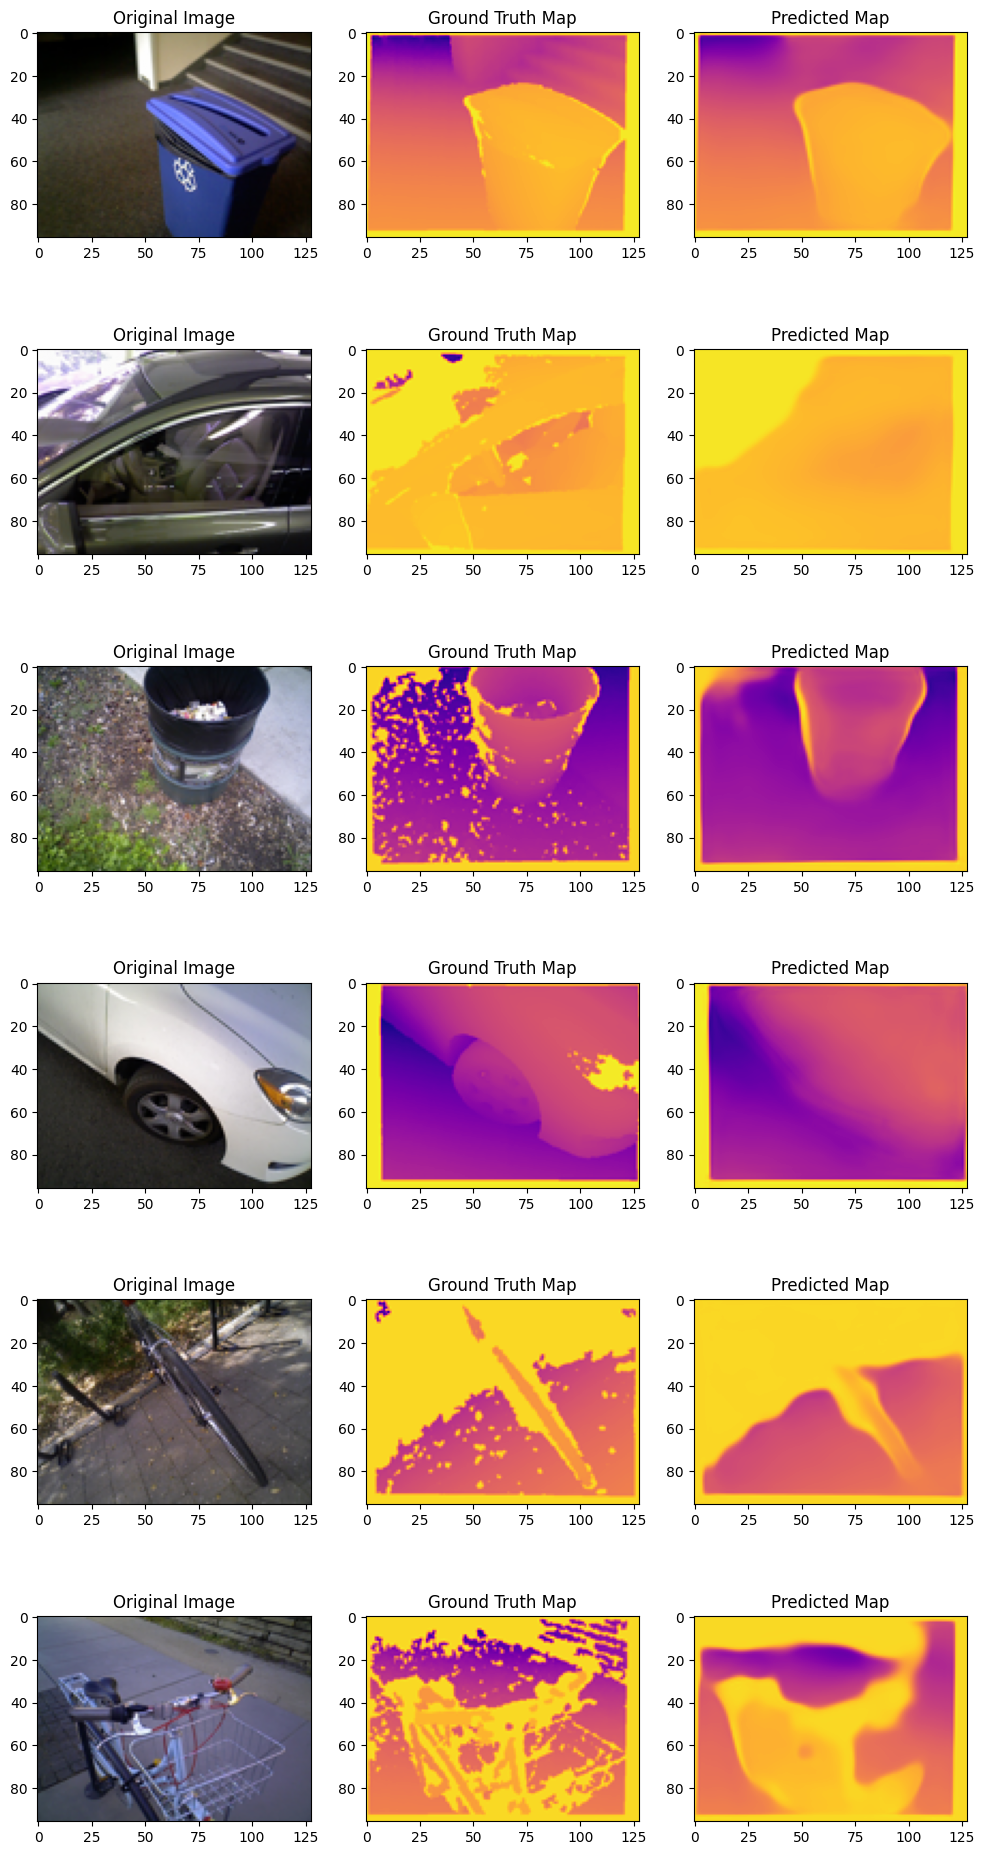

In [ ]:
show_predictions(X_train, Y_train, nums=[90, 878, 326, 57, 267, 264])